In [1]:
import torchhd
import torch
from dataloader import read_points, read_semlabels
from tqdm import tqdm
from scipy.spatial import distance
from sklearn.neighbors import KDTree

In [3]:
points = read_points(f'D:/Documents/Escuela/SEEL/LiDARSegHD/Dataset_TLS/dense_dataset_subsample/sequences/00/velodyne/000001.bin')[:,:3]
print(points.shape)

torch.Size([373228, 3])


In [7]:
emb = torchhd.embeddings.Random(points.shape[0], 2000)
print(emb(torch.IntTensor([0, 1, 3])))

MAPTensor([[-1., -1., -1.,  ...,  1.,  1., -1.],
           [-1.,  1.,  1.,  ...,  1.,  1., -1.],
           [-1.,  1.,  1.,  ...,  1.,  1.,  1.]])


In [9]:
def get_close_points_euclidean(point, points, num_closest): # TODO HD KNN? -> HD clustering by whose work has studied 
    squared_dist = torch.sum((point-points)**2, 1)
    dist = torch.sqrt(squared_dist)
    index_closest_points = torch.topk(dist, num_closest+1, largest=False)
    return index_closest_points.indices[1:]

In [15]:
emb_pos = torchhd.embeddings.Random(3, 2000)

In [28]:
H = torch.zeros(1,2000)
close_p = 3
j = [j for j in range(close_p)]

for i,p in tqdm(enumerate(points)):
    idxs = get_close_points_euclidean(p, points, close_p)
    h = torch.zeros((1,2000))
    x = torchhd.bind(emb(torch.IntTensor([int(id) for id in idxs])), emb_pos(torch.IntTensor(j)))
    for j_i in j:
        h = torchhd.bundle(x[j_i], h)
    H = torchhd.bundle(H, torchhd.bind(emb(torch.IntTensor([i])), h))

5163it [01:03, 81.06it/s]


KeyboardInterrupt: 

In [4]:
H = torch.zeros(1,2000)
close_p = 3
j = [j for j in range(close_p)]

tree = KDTree(points)

In [16]:
# For finding K neighbors of P1 with shape (1, 3)

for i,p in tqdm(enumerate(points)):
    distances, indices = tree.query(torch.reshape(p, (1,3)), close_p+1)
    indices = indices[0][1:]
    h = torch.zeros((1,2000))
    x = torchhd.bind(emb(torch.IntTensor([int(id) for id in indices])), emb_pos(torch.IntTensor(j)))
    for j_i in j:
        h = torchhd.bundle(x[j_i], h)
    H = torchhd.bundle(H, torchhd.bind(emb(torch.IntTensor([i])), h))

373228it [03:04, 2023.24it/s]


In [14]:
import torch
import torchhd
import rff

X = torch.randn(3)
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=3, encoded_size=500)
Xp = encoding(X).sign()
print(Xp.shape)


torch.Size([1000])


# Density Tests

In [5]:
import tensorflow as tf
import numpy as np

def knn_kdtree(nsample, xyz, new_xyz):
    batch_size = xyz.shape[0]
    n_points = new_xyz.shape[1]

    indices = np.zeros((batch_size, n_points, nsample), dtype=np.int32)
    for batch_idx in range(batch_size):
        X = xyz[batch_idx, ...]
        q_X = new_xyz[batch_idx, ...]
        kdt = KDTree(X, leaf_size=30)
        _, indices[batch_idx] = kdt.query(q_X, k = nsample)

    return indices

def kernel_density_estimation(pts, sigma, kpoint = 32, is_norm = False):
    
    batch_size = pts.get_shape()[0]
    num_points = pts.get_shape()[1]
    if num_points < kpoint:
        kpoint = num_points.value - 1
    point_indices = tf.py_func(knn_kdtree, [kpoint, pts, pts], tf.int32)
    batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, kpoint, 1))
    idx = tf.concat([batch_indices, tf.expand_dims(point_indices, axis = 3)], axis = 3)
    idx.set_shape([batch_size, num_points, kpoint, 2])

    grouped_pts = tf.gather_nd(pts, idx)
    grouped_pts -= tf.tile(tf.expand_dims(pts, 2), [1,1,kpoint,1]) # translation normalization

    R = tf.sqrt(sigma)
    xRinv = tf.div(grouped_pts, R)
    quadform = tf.reduce_sum(tf.square(xRinv), axis = -1)
    logsqrtdetSigma = tf.log(R) * 3
    mvnpdf = tf.exp(-0.5 * quadform - logsqrtdetSigma - 3 * tf.log(2 * 3.1415926) / 2)
    mvnpdf = tf.reduce_sum(mvnpdf, axis = 2, keepdims = True)

    scale = 1.0 / kpoint
    density = tf.multiply(mvnpdf, scale)

    if is_norm:
        #grouped_xyz_sum = tf.reduce_sum(grouped_xyz, axis = 1, keepdims = True)
        density_max = tf.reduce_max(density, axis = 1, keepdims = True)
        density = tf.div(density, density_max)

    return density

[[-0.56038041 -0.73218527  1.59596687 ... -1.61075268 -0.50291417
  -1.1376416 ]
 [ 0.44972421 -0.68300001  0.34230126 ... -0.58459975 -0.21147926
   1.64752147]
 [-0.49812941 -1.46444029 -1.10528981 ... -0.49732247  0.18227881
   0.25145784]]
0.0531115644101374
0.001249971551908207
[[ 0.14298926 -0.00266797  0.00481468]
 [-0.00266797  0.1382757  -0.00781998]
 [ 0.00481468 -0.00781998  0.13760091]]
(1000,)


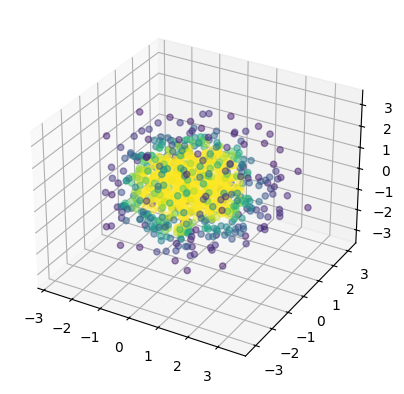

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Generate example 3D data
x = np.random.normal(size=1000)
y = np.random.normal(size=1000)
z = np.random.normal(size=1000)

# Perform kernel density estimation
xyz = np.vstack([x, y, z])
print(xyz)
kde = gaussian_kde(xyz)

# Create a grid of points to evaluate the KDE
xmin, ymin, zmin = x.min(), y.min(), z.min()
xmax, ymax, zmax = x.max(), y.max(), z.max()
xi, yi, zi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j, zmin:zmax:100j]
positions = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])

# Evaluate the KDE at each point in the grid
density = kde(xyz)
print(np.max(density))
print(np.min(density))
print(kde.covariance)
print(density.shape)

# Plot the 3D data and KDEs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot of the original data points
ax.scatter(x, y, z, alpha=0.5, color=plt.cm.viridis(density*50))


1.1241791
0.06274534


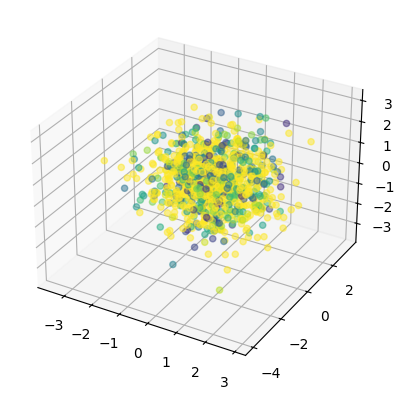

In [8]:
import time
from sklearn.neighbors import KDTree

batch_size = 8
num_point = 1000
pts = np.random.randn(batch_size, num_point, 3).astype('float32')

#import pdb
#pdb.set_trace()

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

points = xyz.reshape((1, 1000, 3)).astype('float32')
points = tf.convert_to_tensor(points)
#density = kernel_density_estimation_ball(points, 1.0)
#0.05701692933058109
#0.0013062706334757174
density = kernel_density_estimation(points, 0.1, kpoint = 32)
with tf.Session() as sess:
    density = density.eval()
density = density.reshape(1000)
print(max(density))
print(min(density))

# Plot the 3D data and KDEs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot of the original data points
ax.scatter(x, y, z, alpha=0.5, color=plt.cm.viridis(density*2))

torch.Size([1000, 10000])
torch.Size([10000])
MAPTensor(-0.0091)
MAPTensor(0.1877)


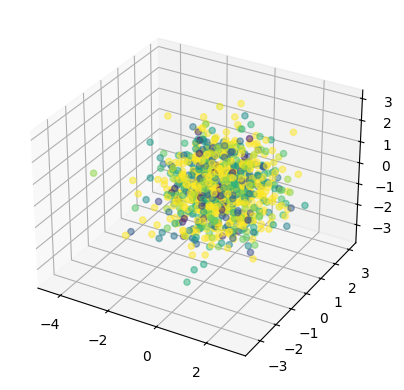

In [73]:
import rff
import torch
import torchhd
import math

#kernel_dens = rff.layers.BasicEncoding()
kernel_dens = rff.layers.GaussianEncoding(sigma=0.95, input_size=3, encoded_size=int(10000/2))
#kernel_dens = torchhd.embeddings.Sinusoid(3,10000)
#kernel_dens = rff.layers.PositionalEncoding(sigma=math.sqrt(33), m=1600)

# All of the points?
xyz_tensor = torch.Tensor(xyz).reshape((1000,3))
dens_enc = kernel_dens(xyz_tensor)
dens_hypervector = torch.sum(dens_enc, dim=0)

p = kernel_dens(xyz_tensor)
print(p.shape)
print(dens_hypervector.shape)
dens = torchhd.cosine_similarity(dens_hypervector, p)
print(torch.min(dens))
print(torch.max(dens))

# Plot the 3D data and KDEs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot of the original data points
ax.scatter(x, y, z, alpha=0.5, color=plt.cm.viridis(dens*20))
    

0.5995692014694214
0.07293101400136948
[0.3121511936187744, 0.16036957502365112, 0.2666985094547272, 0.11705917119979858, 0.36860325932502747, 0.09373191744089127, 0.43906956911087036, 0.3174121677875519, 0.30097058415412903, 0.22887486219406128, 0.23062753677368164, 0.42467981576919556, 0.3202844262123108, 0.12214389443397522, 0.41418707370758057, 0.359933465719223, 0.11394699662923813, 0.32483214139938354, 0.22624588012695312, 0.4090912938117981, 0.355774462223053, 0.2998175323009491, 0.14904335141181946, 0.23818139731884003, 0.36128902435302734, 0.4147348701953888, 0.3726138174533844, 0.10562966018915176, 0.3033202588558197, 0.12855081260204315, 0.14275626838207245, 0.24852009117603302, 0.2484683096408844, 0.392572820186615, 0.15612922608852386, 0.1503676325082779, 0.09553644806146622, 0.19809910655021667, 0.24266186356544495, 0.1436060667037964, 0.47684749960899353, 0.2698087692260742, 0.3399500250816345, 0.362845242023468, 0.19997158646583557, 0.16918127238750458, 0.20699055492877

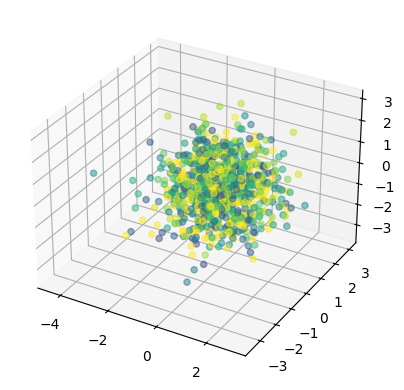

In [89]:
# Only 64
dens = [0]*1000

kernel_dens = rff.layers.GaussianEncoding(sigma=0.8, input_size=3, encoded_size=int(10000/2))

points = xyz.reshape((1, 1000, 3)).astype('float32')
points = tf.convert_to_tensor(points)
point_indices = tf.py_func(knn_kdtree, [64, points, points], tf.int32)
with tf.Session() as sess:
    point_indices = point_indices.eval()
xyz_reshape = xyz.reshape((1000,3))
for p in point_indices[0]:
    xyz_p = xyz_reshape[p]
    xyz_tensor = torch.Tensor(xyz_p)
    dens_enc = kernel_dens(xyz_tensor)
    dens_hypervector = torch.sum(dens_enc, dim=0)
    p_each = kernel_dens(xyz_tensor[0])
    dens[p[0]] = float(torchhd.cosine_similarity(dens_hypervector, p_each))

print(max(dens))
print(min(dens))
print(dens)

# Plot the 3D data and KDEs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot of the original data points
ax.scatter(x, y, z, alpha=0.5, color=plt.cm.viridis([i*3 for i in dens]))

In [47]:
points = xyz.reshape((1, 1000, 3)).astype('float32')
points = tf.convert_to_tensor(points)
point_indices = tf.py_func(knn_kdtree, [64, points, points], tf.int32)
with tf.Session() as sess:
    point_indices = point_indices.eval()
print(point_indices[0][0])

[  0  53 455 697 980 543 564 542 395 307 549 696 464 571 894 605 810 168
 577 726 551 217 427 100 945 145 191 293 905 796 821  65 615 809 507 440
 338 209  96 157  32  89 339 710 426 835 944 570 621 502 434  47 783 866
 705 476 689 364 761 732 591 112 583 317]


In [ ]:
class RFF():
    projection: Array = eqx.field(converter=jnp.asarray)
    bias: Array = eqx.field(converter=jnp.asarray)
    quantize: bool = eqx.field(static=True)

    def __init__(
        self,
        features: int,
        dimensions: int,
        bandwidth: ArrayLike,
        key: np.ndarray = jax.random.PRNGKey(0),
        quantize: bool = False,
    ):
        super().__init__()

        self.quantize = quantize

        if isinstance(bandwidth, float):
            bandwidth = jnp.eye(features) * bandwidth
        elif bandwidth.ndim == 1:  # type: ignore
            bandwidth = jnp.diag(bandwidth)

        _cov = features / bandwidth**2
        _inf_mask = jnp.isinf(_cov)
        _cov = jnp.where(_inf_mask, 0.0, _cov)
        _scale = jnp.sqrt(_cov)

        key, subkey = jax.random.split(key)
        self.projection = jax.random.normal(key, (dimensions, features)) @ _scale
        self.bias = jax.random.uniform(
            subkey, (dimensions,), minval=0, maxval=2 * jnp.pi
        )

    @jax.jit
    def _proj(self, x: Array) -> Array:
        _proj = einsum(x, self.projection, "b f, d f -> b d")
        _cos = jnp.cos(_proj + self.bias)
        _vec = _cos * jnp.sqrt(2 / self.projection.shape[0])

        return _vec

    def __call__(self, x: ArrayLike) -> Fourier:
        if not isinstance(x, jnp.ndarray):
            x = jnp.asarray(x)

        _res = self._proj(x)

        if self.quantize:
            _res = jnp.sign(_res)

        return Fourier(array=_res)

In [ ]:
_const = 2000 * bw.squeeze() * (jnp.pi * 2) ** 0.5 # For Bandwith = (1) Making valid prob. values